In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
from collections import defaultdict
from xgboost import XGBClassifier
from IPython.display import display
from sklearn.linear_model import LogisticRegression

## Data Cleaning

## 500K dataset cleaning (with riley's code)

In [2]:
def clean_party_create_infer():
    corrected_data  = pd.read_csv("/Users/nirugidla/Documents/GitHub/milestone2_MADS/data_500k.csv", low_memory=False)
    #corrected_data  = pd.read_csv("/Users/nirugidla/Documents/GitHub/milestone2_MADS/surveydata.csv", low_memory=False).sample(1000)
    
    corrected_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

    corrected_data.loc[(corrected_data['STATE'] == 'SD') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'
    states_to_update = ['DC', 'LA', 'RI']
    corrected_data.loc[(corrected_data['STATE'].isin(states_to_update)) & (corrected_data['PARTY_CODE'] == 'U'), 'PARTY_CODE'] = 'N'
    corrected_data.loc[(corrected_data['STATE'] == 'OK') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'

    infer_party_mapping = defaultdict(lambda: float('nan'))
    infer_party_mapping.update({'D': 'D', 'E': 'D', 'R': 'R', 'S': 'R', 'L': 'R'})

    new_columns_df = pd.DataFrame()
    new_columns_df['INFER_PARTY'] = corrected_data['PARTY_CODE'].map(infer_party_mapping)
    
    party_code_mapping = {
        'E': float('nan'),
        'S': float('nan'),
        'U': float('nan'),
        'A': 'O',
        'B': 'O',
        'C': 'O',
        'F': 'O',
        'G': 'O',
        'H': 'O',
        'I': 'O',
        'J': 'O',
        'K': 'O',
        'P': 'O',
        'Q': 'O',
        'T': 'O',
        'V': 'O',
        'W': 'O',
        'Y': 'O',
        'Z': 'O'
    }
    
    corrected_data['PARTY_CODE'] = corrected_data['PARTY_CODE'].replace(party_code_mapping)
    
    voter_columns = [col for col in corrected_data.columns if col.startswith("VTR")]

    new_columns_df['VTR_TOTAL_DVOTES'] = corrected_data[voter_columns].isin(['D', 'M', 'Z']).sum(axis=1)
    new_columns_df['VTR_TOTAL_RVOTES'] = corrected_data[voter_columns].isin(['R', 'P', 'X']).sum(axis=1)

    conditions = [
        new_columns_df['VTR_TOTAL_DVOTES'] - new_columns_df['VTR_TOTAL_RVOTES'] >= 2,
        new_columns_df['VTR_TOTAL_RVOTES'] - new_columns_df['VTR_TOTAL_DVOTES'] >= 2
    ]
    choices = ['D', 'R']

    new_columns_df['VTR_INFER_PARTY'] = np.select(conditions, choices, default=np.nan)

    corrected_data = pd.concat([corrected_data, new_columns_df], axis=1)
    
    corrected_data.loc[(corrected_data['VTR_INFER_PARTY'] == 'D') , 'INFER_PARTY'] = 'D'
    corrected_data.loc[(corrected_data['VTR_INFER_PARTY'] == 'R') , 'INFER_PARTY'] = 'R'

    columns_to_check = ['VTR_PPP16', 'VTR_GEN16', 'VTR_GEN18', 'VTR_PRI20', 'VTR_PPP20', 'VTR_GEN20', 'VTR_PRI22', 'VTR_GEN22']
    democrat_values = ['D', 'M', 'Z']
    republican_values = ['R', 'P', 'X']

    for column in columns_to_check:
        corrected_data.loc[corrected_data[column].isin(democrat_values), 'INFER_PARTY'] = 'D'
        corrected_data.loc[corrected_data[column].isin(republican_values), 'INFER_PARTY'] = 'R'
    
    corrected_data.drop(columns=["VTR_INFER_PARTY", "VTR_TOTAL_DVOTES", "VTR_TOTAL_RVOTES"], inplace=True)
    
    return corrected_data

engineered_data = clean_party_create_infer()
print(engineered_data.shape)

(500000, 299)


In [3]:
def additional_cleaning(data):
    
    # Calculate the percentage of missing data for each column
    missing_data_percentage = data.isnull().mean() * 100

    # Identify columns with more than 90% missing data
    cols_to_remove = missing_data_percentage[missing_data_percentage > 90].index.tolist()
    print(cols_to_remove)
   
    # Drop the identified columns
    data = data.drop(columns=cols_to_remove)

    def convert_with_leading_zero(value):
        if isinstance(value, int) and 0 <= value < 10:
            return '0' + str(value)
        else:
            return str(value)

    data['CONG_DIST'] = data['CONG_DIST'].apply(convert_with_leading_zero)
        
    data['CNS_MEDINC'] = data['CNS_MEDINC'].astype('Int64')
    data['YEARBUILT'] = data['YEARBUILT'].astype('Int64')
    data['VOTER_CNT'] = data['VOTER_CNT'].str.strip().astype('Int64')
    data['VOTER_TRLR'] = data['VOTER_TRLR'].astype(str)
    
    return data
engineered_data = additional_cleaning(engineered_data)
print(engineered_data.shape)

['AFAMPROFLS', 'APP_CHILD', 'APP_MENBIG', 'APP_TODDLR', 'APP_WOMEN', 'APP_WOMPET', 'APP_WOMPLS', 'APP_YNGMEN', 'ARTS', 'AUTOACCES', 'BOATING', 'BUS_OWNER', 'CATOWNER', 'CH_0002FEM', 'CH_0002MAL', 'CH_0002UNK', 'CH_0305FEM', 'CH_0305MAL', 'CH_0305UNK', 'CH_0610FEM', 'CH_0610MAL', 'CH_0610UNK', 'CH_1115FEM', 'CH_1115MAL', 'CH_1115UNK', 'CH_1617FEM', 'CH_1617MAL', 'CH_1617UNK', 'CHRISTFAM', 'COL_ANTIQ', 'COL_ARTS', 'COL_COIN', 'COL_SPORT', 'COL_STAMP', 'COMPHOMOFC', 'CURRAFFAIR', 'DIYLIV', 'DON_ANML', 'DON_ARTCUL', 'DON_CHILD', 'DON_ENVIR', 'DON_ENVWLD', 'DON_INTAID', 'DON_OTHER', 'DON_POLCONS', 'DON_POLLIB', 'DON_RELIG', 'DON_VET', 'DONATION', 'EDU_ONLINE', 'EQUESTRIAN', 'ETHNICCONF', 'GAMING', 'GRANDCHLD', 'HH_SENIOR', 'HH_VETERAN', 'HH_YOUNGAD', 'HIGHBROW', 'HIGHENDAPP', 'HISTMIL', 'HOMEOFFICE', 'HUNTING', 'HUNTSHOOT', 'INV_ACTIVE', 'MAIL_DONOR', 'MOTORCYCLE', 'NASCAR', 'PARENTING', 'POOL', 'PRFL_ACTIVE_MIL', 'PRFL_BLM_SUPPORT', 'PRFL_CHOICELIFE', 'PRFL_CLINTON_SUPPORT', 'PRFL_EDUCATIO

In [4]:
remove_columns = [
    'PRFL_LGBT_SUPPORT',
    'PRFL_LIBERAL_NEWS',
    'PRFL_MARIJUANA_REFORM',
    'PRFL_BIDEN_SUPPORT',
    'PRFL_BORDER_SECURITY',
    'PRFL_CONSERVATIVE_NEWS',
    'PRFL_IMMIGRATION_REFORM',
    'PRFL_OBAMA',
    'PRFL_PERSUADABLE_VOTER',
    'PRFL_POLITICAL_IDEOLOGY',
    'PRFL_SANDERS_SUPPORT',
    'PRFL_TRUMP_SUPPORT',
    'ZIP',
    
    'VTR_GEN00', 'VTR_GEN01', 'VTR_GEN02', 'VTR_GEN03', 'VTR_GEN04', 'VTR_GEN05', 'VTR_GEN06', 'VTR_GEN07', 'VTR_GEN08', 'VTR_GEN09', 'VTR_GEN10', 'VTR_GEN11', 'VTR_GEN12', 'VTR_GEN13', 'VTR_GEN14', 'VTR_GEN15', 'VTR_GEN16', 'VTR_GEN17', 'VTR_GEN18', 'VTR_GEN19', 'VTR_GEN20', 'VTR_GEN21', 'VTR_GEN22', 'VTR_OTH00', 'VTR_OTH01', 'VTR_OTH02', 'VTR_OTH03', 'VTR_OTH04', 'VTR_OTH05', 'VTR_OTH06', 'VTR_OTH07', 'VTR_OTH08', 'VTR_OTH09', 'VTR_OTH10', 'VTR_OTH11', 'VTR_OTH12', 'VTR_OTH13', 'VTR_OTH14', 'VTR_OTH15', 'VTR_OTH16', 'VTR_OTH17', 'VTR_OTH18', 'VTR_OTH19', 'VTR_OTH20', 'VTR_OTH21', 'VTR_OTH22', 'VTR_PPP00', 'VTR_PPP04', 'VTR_PPP08', 'VTR_PPP12', 'VTR_PPP16', 'VTR_PPP20', 'VTR_PRI00', 'VTR_PRI01', 'VTR_PRI02', 'VTR_PRI03', 'VTR_PRI04', 'VTR_PRI05', 'VTR_PRI06', 'VTR_PRI07', 'VTR_PRI08', 'VTR_PRI09', 'VTR_PRI10', 'VTR_PRI11', 'VTR_PRI12', 'VTR_PRI13', 'VTR_PRI14', 'VTR_PRI15', 'VTR_PRI16', 'VTR_PRI17', 'VTR_PRI18', 'VTR_PRI19', 'VTR_PRI20', 'VTR_PRI21', 'VTR_PRI22',
    
      'PRFL_CHOICELIFE', "PRFL_GUN_CONTROL",'PRFL_MARRIAGE_EQUALITY', 'PRFL_TEAPARTY',
    'VP_PPP', "AI_COUNTY_NAME", 'PRFL_CLINTON_SUPPORT',
     'CNSUS_PCTW', 'PARTY_MIX', 'PRFL_MINWAGE', 'PRFL_FENCE_SITTER', "RECORD_ID", 'CNSUS_PCTA',
    'PRFL_BLM_SUPPORT', 'PRFL_METOO_SUPPORT', 'PRFL_HEALTHCARE_REFORM','DON_POLLIB', 'PRFL_2NDAMEND', 'FUND_POLIT', 'DON_POLCONS', 
    
   'PARTY_CODE','ST_LO_HOUS', 'ST_UP_HOUS', 'CENSUS_ST', 'COUNTY_ST',
    #'AGE'
]
# Drop the list of columns from the dataset
engineered_data.drop(columns=remove_columns, errors='ignore', inplace=True)
print(engineered_data.shape)

(500000, 94)


In [5]:
print(engineered_data.columns)

Index(['ADD_TYPE', 'AGE', 'AIRCOND', 'ASSMLCODE', 'AUTOWORK', 'BROADERLIV',
       'CARDUSER', 'CENSUS_TRK', 'CNS_MEDINC', 'CNSUS_PCTB', 'CNSUS_PCTH',
       'CNSUS_PCTI', 'CNSUS_PCTM', 'CNSUS_PCTO', 'CNSUS_PCTP', 'COMPUTERS',
       'CONG_DIST', 'COOK_GEN', 'COUNTY_TYPE', 'CRD_RANGE', 'CREDRATE',
       'DEPTSTCRD', 'DIETING', 'DOGOWNER', 'DON_CHARIT', 'DON_HEALTH',
       'DON_POLIT', 'EDUCATION', 'ETHNIC_INFER', 'ETHNICCODE', 'ETHNICGRP',
       'EXER_GROUP', 'GARDENER', 'GENDER_MIX', 'GENERATION', 'GOLF',
       'HEALTHBEAU', 'HEATHMED', 'HH_NUMGEN', 'HH_SIZE', 'HITECHLIV',
       'HOME_DECOR', 'HOMEMKTVAL', 'HOMEOWNER', 'HOMEOWNRNT', 'INCOMESTHH',
       'LANGUAGE', 'LENGTH_RES', 'LIFESTAGE_CLUSTER', 'MAILORDBUY',
       'MAILORDRSP', 'NETWORTH', 'NUMCHILD', 'OCCDETAIL', 'OCCUPATION',
       'PERSONS_HH', 'PETS', 'PRESENCHLD', 'PRFL_AMZN_PRIME',
       'PRFL_ANML_RIGHTS', 'PRFL_ENVIRONMENT', 'PRFL_INSURANCE', 'PRFL_TAXES',
       'RD_GEN', 'RD_RELIG', 'RELIGION', 'SEX', 'SPEC_FOOT

In [6]:
engineered_data.sample(10)

,ADD_TYPE,AGE,AIRCOND,ASSMLCODE,AUTOWORK,BROADERLIV,CARDUSER,CENSUS_TRK,CNS_MEDINC,CNSUS_PCTB,...,TRAIL_CNT,TRAVEL,VOTER_CNT,VOTER_TRLR,VP_GEN,VP_OTH,VP_PRI,WORKWOMAN,YEARBUILT,INFER_PARTY
430301,H,25.0,NaN,NaN,NaN,NaN,NaN,105207.0,<NA>,53.191489,...,1,NaN,0,0,0.00,0.00,0.0,NaN,<NA>,NaN
274698,S,39.0,NaN,A,NaN,NaN,NaN,1414.0,<NA>,0.000000,...,2,NaN,6,2,33.33,0.00,0.0,NaN,1981,R
427594,S,68.0,NaN,NaN,NaN,NaN,NaN,532700.0,<NA>,42.905405,...,1,NaN,0,0,0.00,0.00,0.0,NaN,<NA>,D
243841,S,60.0,NaN,NaN,Y,NaN,Y,951101.0,607,26.484018,...,3,NaN,37,2,70.00,10.00,40.0,Y,1986,R
201032,S,79.0,I,NaN,NaN,NaN,Y,270200.0,923,0.000000,...,1,NaN,23,0,50.00,0.00,30.0,NaN,1920,D
468846,S,54.0,NaN,NaN,NaN,NaN,Y,12903.0,<NA>,0.000000,...,1,NaN,8,1,20.00,10.00,0.0,Y,<NA>,R
309765,S,76.0,A,NaN,Y,NaN,Y,14304.0,<NA>,0.000000,...,2,NaN,25,1,90.00,0.00,10.0,NaN,2019,R
483066,S,64.0,A,NaN,NaN,NaN,NaN,30370.0,1518,2.028398,...,1,Y,10,1,42.86,42.86,0.0,NaN,1994,NaN
272111,S,57.0,NaN,NaN,NaN,NaN,NaN,11003.0,1411,1.311475,...,1,NaN,35,1,90.00,10.00,10.0,NaN,1999,D
129899,S,37.0,NaN,NaN,NaN,NaN,NaN,10700.0,617,0.000000,...,1,Y,3,0,30.00,0.00,0.0,NaN,<NA>,R


In [7]:
def preprocess_dataframe(df):
    # Initial count of numerical and non-numerical columns
    initial_numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    initial_non_numerical_cols = df.select_dtypes(include=['object']).columns

    print(f"Initial Numerical Columns Count: {len(initial_numerical_cols)}")
    print(f"Initial Non-Numerical Columns Count: {len(initial_non_numerical_cols)}")

    # Create a copy of the DataFrame to avoid modifying the original one
    converted_data = df.copy()

    # Initialize counters for numerical and non-numerical columns
    num_cols_count = 0
    non_num_cols_count = 0

    # Loop through each column and try to convert it to numerical data types
    for col in converted_data.columns:
        try:
            # Try converting to 'int64'
            converted_data[col] = converted_data[col].astype('int64')
            num_cols_count += 1
        except ValueError:
            try:
                # If that fails, try converting to 'float64'
                converted_data[col] = converted_data[col].astype('float64')
                num_cols_count += 1
            except ValueError:
                # If both fail, the column is genuinely non-numeric
                non_num_cols_count += 1
                print(f"Column {col} couldn't be converted to 'int64' or 'float64'. It is non-numeric.")

    # Display the data types after the conversion
    print("\nData types after conversion:")
    print(converted_data.dtypes)

    # Display count of numerical and non-numerical columns
    print(f"\nTotal Numerical Columns after conversion: {num_cols_count}")
    print(f"Total Non-Numerical Columns after conversion: {non_num_cols_count}")

    return converted_data

# Assuming your DataFrame is named 'engineered_data'
processed_data = preprocess_dataframe(engineered_data)
print(processed_data.shape)

Initial Numerical Columns Count: 24
Initial Non-Numerical Columns Count: 70
Column ADD_TYPE couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column AIRCOND couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column ASSMLCODE couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column AUTOWORK couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column BROADERLIV couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column CARDUSER couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column COMPUTERS couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column COOK_GEN couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column COUNTY_TYPE couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column CREDRATE couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column DEPTSTCRD couldn't be converted to 'int64' or 'float64'. It is non-numeric.
Column DIETING 

## time decorator

In [8]:
def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        return result
    return wrapper

### Feature Selection with Random Forest Generator

In [11]:
@timer_decorator
def run_random_forest(data, num_runs=1, top_N_features=10):
    results_list = []

    for run in range(1, num_runs + 1):
        print(f"Starting Random Forest run {run}...")
        
        # Copy the original data to work with
        data_copy = data.copy()
        
        # Drop rows with missing 'INFER_PARTY'
        data_copy = data_copy.dropna(subset=['INFER_PARTY'])
        
        # Encode all object type columns
        le = LabelEncoder()
        for col in data_copy.select_dtypes(include=['object']).columns:
            data_copy[col] = le.fit_transform(data_copy[col].astype(str))
        
        # Impute missing values with column means
        imputer = SimpleImputer(strategy='mean')
        data_copy = imputer.fit_transform(data_copy)
        
        # Convert back to DataFrame after imputation
        data_copy = pd.DataFrame(data_copy, columns=data.columns)
        
        # Extract features and target variable
        X = data_copy.drop(columns=['INFER_PARTY'])
        y = data_copy['INFER_PARTY']
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Initialize Random Forest Classifier
        rf = RandomForestClassifier(random_state=42+run)
        
        # Fit the model
        rf.fit(X_train, y_train)
        
        # Make predictions
        y_pred = rf.predict(X_test)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        
        # Get top N features using feature_importances_
        top_feature_indices = np.argsort(rf.feature_importances_)[::-1][:top_N_features]
        top_features = X.columns[top_feature_indices].tolist()
        
        # Append results to the list
        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'Precision': precision,
            'F1_Score': f1,
            'Recall': recall,
            'Top_N_Features': top_features
        })

    # Create a DataFrame from the results list
    results_df = pd.DataFrame(results_list)

    return results_df

# Assuming processed_data is your preprocessed dataset
result = run_random_forest(engineered_data, num_runs=1, top_N_features=10)
result

Starting Random Forest run 1...
Elapsed time: 74.25 seconds


,Run,Accuracy,Precision,F1_Score,Recall,Top_N_Features
0,1,0.742583,0.717987,0.734781,0.752379,"[TOD_PRES_R_2016_PREC, TOD_PRES_D_2016_PREC, T..."


In [12]:
for n in result['Top_N_Features']:
    print(n)
    break

['TOD_PRES_R_2016_PREC', 'TOD_PRES_D_2016_PREC', 'TOD_PRES_D_2020_PREC', 'TOD_PRES_D_2016', 'TOD_PRES_R_2016', 'TOD_PRES_R_2020_PREC', 'ETHNIC_INFER', 'CNSUS_PCTB', 'CENSUS_TRK', 'TOD_PRES_DIFF_2016_PREC']


#### Plot for Random Forest Generator for Feature Selection

Starting Random Forest run for feature importance...


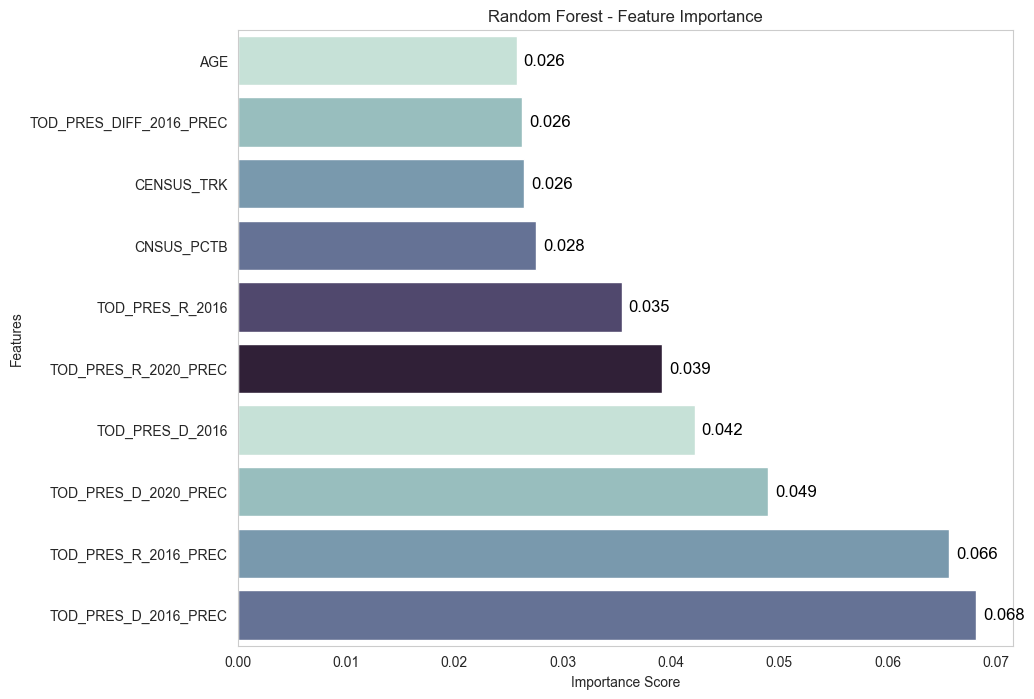

In [13]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = pd.DataFrame({'feature': names, 'importance': importance})
    feature_importance = feature_importance.sort_values(by='importance', ascending=True)
    
    plt.figure(figsize=(10, 8))
    
    cubehelix_palette = sns.cubehelix_palette(start=.5, rot=-.5)
    
    ax = sns.barplot(x="importance", y="feature", data=feature_importance, palette=cubehelix_palette)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.3f}', 
                    (p.get_width(), p.get_y() + p.get_height() / 2.), 
                    ha='left', 
                    va='center', 
                    fontsize=12, 
                    color='black',
                    xytext=(5, 0), 
                    textcoords='offset points')
    
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(False)
    plt.show()

def run_random_forest_for_feature_importance(data, top_N_features=10):
    print("Starting Random Forest run for feature importance...")

    # Copy the original data to work with
    data_copy = data.copy()

    # Drop rows with missing 'INFER_PARTY'
    data_copy = data_copy.dropna(subset=['INFER_PARTY'])

    # Encode all object type columns
    le = LabelEncoder()
    for col in data_copy.select_dtypes(include=['object']).columns:
        data_copy[col] = le.fit_transform(data_copy[col].astype(str))

    # Impute missing values with column means
    imputer = SimpleImputer(strategy='mean')
    data_copy = imputer.fit_transform(data_copy)

    # Convert back to DataFrame after imputation
    data_copy = pd.DataFrame(data_copy, columns=data.columns)

    # Extract features and target variable
    X = data_copy.drop(columns=['INFER_PARTY'])
    y = data_copy['INFER_PARTY']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(random_state=42)

    # Fit the model
    rf.fit(X_train, y_train)

    # Get top N features using feature_importances_
    top_feature_indices = np.argsort(rf.feature_importances_)[::-1][:top_N_features]
    top_features = X.columns[top_feature_indices].tolist()

    # Plot feature importance
    plot_feature_importance(rf.feature_importances_[top_feature_indices], top_features, 'Random Forest')

    return top_features

# Assuming processed_data is your DataFrame
top_features = run_random_forest_for_feature_importance(processed_data, top_N_features=10)


In [ ]:
top_features['Top_N_Features'][0]

### Feature Selection with Gradient boosting

In [15]:
@timer_decorator
def run_gradient_boosting(data, num_runs=1, top_N_features=10, pos_label='D'):
    results_list = []
    
    for run in range(1, num_runs + 1):
        print(f"Starting Gradient Boosting run {run}...")
        
        # Copy the original data
        data_copy = data.copy()
        data_copy = data_copy.dropna(subset=['INFER_PARTY'])
        
        # Separate target and features
        y = data_copy['INFER_PARTY']
        X = data_copy.drop('INFER_PARTY', axis=1)
        
        # One-hot encoding
        X = pd.get_dummies(X, drop_first=True)
        
        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
        
        # Train-test split
        if y.nunique() > 1:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        else:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Initialize and fit model
        gb = GradientBoostingClassifier(random_state=42)
        gb.fit(X_train, y_train)
        
        # Make predictions
        y_pred = gb.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, pos_label=pos_label)
        recall = recall_score(y_test, y_pred, pos_label=pos_label)
        precision = precision_score(y_test, y_pred, pos_label=pos_label)
        
        # Get top N features
        k_best = SelectKBest(score_func=chi2, k=top_N_features)
        k_best.fit(X_train, y_train)
        top_feature_indices = np.argsort(k_best.scores_)[::-1][:top_N_features]
        top_features = X.columns[top_feature_indices].tolist()
        
        # Store results
        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'Precision': precision,
            'F1_Score': f1,
            'Recall': recall,
            'Top_N_Features': top_features
        })

    results_df = pd.DataFrame(results_list)

    return results_df

# Assuming engineered_data is your preprocessed dataset
result = run_gradient_boosting(processed_data, num_runs=1, top_N_features=10, pos_label='D')
result

Starting Gradient Boosting run 1...
Elapsed time: 330.53 seconds


,Run,Accuracy,Precision,F1_Score,Recall,Top_N_Features
0,1,0.740279,0.767441,0.745534,0.724842,"[OCCDETAIL_W523, ETHNICCODE_HA, OCCDETAIL_T899..."


In [ ]:
result['Top_N_Features'][0]

#### Plot for Gradient Boosting for Feature Selection

In [ ]:
@timer_decorator
def run_gradient_boosting(data, pos_label='D', top_N_features=10):
    results_list = []
    
    print(f"Starting Gradient Boosting...")
    
    # Copy the original data
    data_copy = data.copy()
    data_copy = data_copy.dropna(subset=['INFER_PARTY'])
    
    # Separate target and features
    y = data_copy['INFER_PARTY']
    X = data_copy.drop('INFER_PARTY', axis=1)
    
    # One-hot encoding
    X = pd.get_dummies(X, drop_first=True)
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Initialize and fit model
    gb = GradientBoostingClassifier(random_state=42)
    gb.fit(X, y)
    
    # Make predictions
    y_pred = gb.predict(X)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, pos_label=pos_label)
    recall = recall_score(y, y_pred, pos_label=pos_label)
    
    # Get top N features
    importance = gb.feature_importances_
    top_feature_indices = np.argsort(importance)[-top_N_features:]
    top_features = X.columns[top_feature_indices].tolist()
    
    
    # Store results
    results_list.append({
        'Accuracy': accuracy,
        'F1_Score': f1,
        'Recall': recall,
        'Top_N_Features': top_features
    })

    results_df = pd.DataFrame(results_list)

    return results_df, gb

# Assuming processed_data is your preprocessed dataset
results_df, gb_model = run_gradient_boosting(processed_data, pos_label='D', top_N_features=10)
results_df

# Function for plotting feature importance
def plot_feature_importance(importance, names, model_type):
    feature_importance = pd.DataFrame({'feature': names, 'importance': importance})
    feature_importance = feature_importance.sort_values(by='importance', ascending=True).tail(10)  # For top 10 features
    
    plt.figure(figsize=(10, 8))
    
    cubehelix_palette = sns.cubehelix_palette(start=.5, rot=-.5)
    
    ax = sns.barplot(x="importance", y="feature", data=feature_importance, palette=cubehelix_palette)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.3f}', 
                    (p.get_width(), p.get_y() + p.get_height() / 2.), 
                    ha='left', 
                    va='center', 
                    fontsize=12, 
                    color='black',
                    xytext=(5, 0), 
                    textcoords='offset points')
    
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(False)
    plt.show()

# Assuming processed_data is your preprocessed dataset
result = run_gradient_boosting(processed_data, pos_label='D')
result

In [ ]:
@timer_decorator
def run_gradient_boosting(data, pos_label='D', top_N_features=10):
    # Get top N features
    importance = gb.feature_importances_
    top_feature_indices = np.argsort(importance)[-top_N_features:]
    top_features = X.columns[top_feature_indices].tolist()  
    return results_df

# Modified plot_feature_importance to include only top N features
def plot_feature_importance(importance, names, model_type, top_features=None):
    feature_importance = pd.DataFrame({'feature': names, 'importance': importance})
    
    # If top_features is provided, filter the DataFrame
    if top_features:
        feature_importance = feature_importance[feature_importance['feature'].isin(top_features)]

    feature_importance = feature_importance.sort_values(by='importance', ascending=True)
    
    plt.figure(figsize=(10, 8))
    
    cubehelix_palette = sns.cubehelix_palette(start=.5, rot=-.5)
    
    ax = sns.barplot(x="importance", y="feature", data=feature_importance, palette=cubehelix_palette)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.3f}', 
                    (p.get_width(), p.get_y() + p.get_height() / 2.), 
                    ha='left', 
                    va='center', 
                    fontsize=12, 
                    color='black',
                    xytext=(5, 0), 
                    textcoords='offset points')
    
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(False)
    plt.show()

# Existing run_gradient_boosting function
@timer_decorator
def run_gradient_boosting(data, pos_label='D', top_N_features=10):
    results_list = []
    
    print(f"Starting Gradient Boosting...")
    
    # Copy the original data and drop NA values for target variable
    data_copy = data.copy()
    data_copy = data_copy.dropna(subset=['INFER_PARTY'])
    
    # Separate target and features
    y = data_copy['INFER_PARTY']
    X = data_copy.drop('INFER_PARTY', axis=1)
    
    # One-hot encoding
    X = pd.get_dummies(X, drop_first=True)
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Initialize and fit model
    gb = GradientBoostingClassifier(random_state=42)
    gb.fit(X, y)
    
    # Make predictions
    y_pred = gb.predict(X)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, pos_label=pos_label)
    recall = recall_score(y, y_pred, pos_label=pos_label)
    precision = precision_score(y, y_pred, pos_label=pos_label)
    
    # Get top N features
    importance = gb.feature_importances_
    top_feature_indices = np.argsort(importance)[-top_N_features:]
    top_features = X.columns[top_feature_indices].tolist()
    
     # Store results
    results_list.append({
        'Accuracy': accuracy,
        'F1_Score': f1,
        'Recall': recall,
        'Precision': precision,
        'Top_N_Features': top_features
    })

    results_df = pd.DataFrame(results_list)
    
    # Plotting feature importance using top_features
    feature_importances = gb.feature_importances_
    plot_feature_importance(feature_importances, X.columns, "Gradient Boosting", top_features=top_features)
    
    return results_df
    
# The run_gradient_boosting function remains the same as before
# Assuming processed_data is your preprocessed dataset
result = run_gradient_boosting(processed_data, pos_label='D', top_N_features=10)
result

In [16]:
for n in result['Top_N_Features']:
    print(n)

['OCCDETAIL_W523', 'ETHNICCODE_HA', 'OCCDETAIL_T899', 'LANGUAGE_S4', 'OCCDETAIL_C123', 'TOD_PRES_DIFF_2016_88R', 'ETHNICCODE_M9', 'ETHNICCODE_HY', 'OCCDETAIL_L398', 'OCCDETAIL_I146']


### Feature Selection with Logistic Regression

In [17]:
@timer_decorator
def run_logistic_regression(data, num_runs=1, top_N_features=10):
    results_list = []

    for run in range(1, num_runs + 1):
        print(f"Starting Logistic Regression run {run}...")
        
        # Copy the original data to work with
        data_copy = data.copy()
        
        # Drop rows with missing 'INFER_PARTY'
        data_copy = data_copy.dropna(subset=['INFER_PARTY'])
        
        # Encode 'INFER_PARTY' column
        le = LabelEncoder()
        data_copy['INFER_PARTY'] = le.fit_transform(data_copy['INFER_PARTY'].astype(str))
        
        # Check for classes with only one instance after sampling and encoding
        class_counts = data_copy['INFER_PARTY'].value_counts()
        min_class_count = class_counts.min()
        
        # Select numerical columns
        numerical_cols = data_copy.select_dtypes(include=['int64', 'float64']).columns
        
        # Drop 'INFER_PARTY' from the numerical columns as it is the target variable
        numerical_cols = numerical_cols.drop('INFER_PARTY')

        # Impute missing values with column means
        imputer = SimpleImputer(strategy='mean')
        data_copy[numerical_cols] = imputer.fit_transform(data_copy[numerical_cols])
        
        # Extract features and target variable
        X = data_copy[numerical_cols]
        y = data_copy['INFER_PARTY']
        
        # Train-test split
        if min_class_count > 1:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
        else:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Initialize Logistic Regression model
        lr = LogisticRegression(C=0.1, max_iter=10000, random_state=42+run)
    
        # Fit the model
        lr.fit(X_train, y_train)
        
        # Make predictions
        y_pred = lr.predict(X_test)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, zero_division='warn')
        precision = precision_score(y_test, y_pred)
        
        # Get top N features using SelectKBest with chi-squared
        k_best = SelectKBest(score_func=chi2, k=top_N_features)
        k_best.fit(X_train, y_train)
        top_feature_indices = np.argsort(k_best.scores_)[::-1][:top_N_features]
        top_features = X.columns[top_feature_indices].tolist()
        
        # Append results to the list
        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'Precision': precision,
            'F1_Score': f1,
            'Recall': recall,
            'Top_N_Features': top_features
        })

    # Create a DataFrame from the results list
    results_df = pd.DataFrame(results_list)

    return results_df

# Assuming processed_data is your dataset, you can call the function like this:
result = run_logistic_regression(processed_data, num_runs=5, top_N_features=30)
result

Starting Logistic Regression run 1...
Starting Logistic Regression run 2...
Starting Logistic Regression run 3...
Starting Logistic Regression run 4...
Starting Logistic Regression run 5...
Elapsed time: 35.09 seconds


,Run,Accuracy,Precision,F1_Score,Recall,Top_N_Features
0,1,0.721342,0.698749,0.712522,0.726848,"[CNSUS_PCTB, TOD_PRES_R_2016_PREC, TOD_PRES_D_..."
1,2,0.721342,0.698749,0.712522,0.726848,"[CNSUS_PCTB, TOD_PRES_R_2016_PREC, TOD_PRES_D_..."
2,3,0.721342,0.698749,0.712522,0.726848,"[CNSUS_PCTB, TOD_PRES_R_2016_PREC, TOD_PRES_D_..."
3,4,0.721342,0.698749,0.712522,0.726848,"[CNSUS_PCTB, TOD_PRES_R_2016_PREC, TOD_PRES_D_..."
4,5,0.721342,0.698749,0.712522,0.726848,"[CNSUS_PCTB, TOD_PRES_R_2016_PREC, TOD_PRES_D_..."


In [ ]:
# @timer_decorator
# def run_logistic_regression(data, sample_size=500, num_runs=1, top_N_features=10):
#     results_list = []
# 
#     for run in range(1, num_runs + 1):
#         print(f"Starting Logistic Regression run {run}...")
#         
#         # Copy the original data to work with
#         data_copy = data.copy()
#         
#         # Drop rows with missing 'INFER_PARTY'
#         data_copy = data_copy.dropna(subset=['INFER_PARTY'])
#         
#         # Sample data
#         data_sample = data_copy.sample(n=sample_size, random_state=42+run)
#         
#         # Encode 'INFER_PARTY' column
#         le = LabelEncoder()
#         data_sample['INFER_PARTY'] = le.fit_transform(data_sample['INFER_PARTY'].astype(str))
#         
#         # Check for classes with only one instance after sampling and encoding
#         class_counts = data_sample['INFER_PARTY'].value_counts()
#         min_class_count = class_counts.min()
#         
#         # Select numerical columns
#         numerical_cols = data_sample.select_dtypes(include=['int64', 'float64']).columns
#         
#         # Drop 'INFER_PARTY' from the numerical columns as it is the target variable
#         numerical_cols = numerical_cols.drop('INFER_PARTY')
# 
#         # Impute missing values with column means
#         imputer = SimpleImputer(strategy='mean')
#         data_sample[numerical_cols] = imputer.fit_transform(data_sample[numerical_cols])
#         
#         # Extract features and target variable
#         X = data_sample[numerical_cols]
#         y = data_sample['INFER_PARTY']
#         
#         # Train-test split
#         if min_class_count > 1:
#             X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
#         else:
#             X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#         
#         scaler = MinMaxScaler()
#         X_train = scaler.fit_transform(X_train)
#         X_test = scaler.transform(X_test)
#         
#         # Initialize Logistic Regression model
#         lr = LogisticRegression(C=0.1, max_iter=10000, random_state=42+run)
#     
#         # Fit the model
#         lr.fit(X_train, y_train)
#         
#         # Make predictions
#         y_pred = lr.predict(X_test)
#         
#         # Calculate evaluation metrics
#         accuracy = accuracy_score(y_test, y_pred)
#         f1 = f1_score(y_test, y_pred)
#         recall = recall_score(y_test, y_pred, zero_division='warn')
#         precision = precision_score(y, y_pred)
#         
#         # Get top N features using SelectKBest with chi-squared
#         k_best = SelectKBest(score_func=chi2, k=top_N_features)
#         k_best.fit(X_train, y_train)
#         top_feature_indices = np.argsort(k_best.scores_)[::-1][:top_N_features]
#         top_features = X.columns[top_feature_indices].tolist()
#         
#         # Append results to the list
#         results_list.append({
#             'Run': run,
#             'Accuracy': accuracy,
#             'Precision': precision,
#             'F1_Score': f1,
#             'Recall': recall,
#             'Top_N_Features': top_features
#         })
# 
#     # Create a DataFrame from the results list
#     results_df = pd.DataFrame(results_list)
# 
#     return results_df
# 
# # Assuming data_500 is your dataset, you can call the function like this:
# result = run_logistic_regression(processed_data, sample_size=500, num_runs=5, top_N_features=30)
# result

#### Plot for Logistic Regression for Feature Selection

In [ ]:
@timer_decorator
def plot_feature_importance(importance, names, model_type):
    feature_importance = pd.DataFrame({'feature': names, 'importance': importance})
    feature_importance = feature_importance.sort_values(by='importance', ascending=True)
    
    plt.figure(figsize=(10, 8))
    
    cubehelix_palette = sns.cubehelix_palette(start=.5, rot=-.5)
    
    ax = sns.barplot(x="importance", y="feature", data=feature_importance, palette=cubehelix_palette)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.3f}', 
                    (p.get_width(), p.get_y() + p.get_height() / 2.), 
                    ha='left', 
                    va='center', 
                    fontsize=12, 
                    color='black',
                    xytext=(5, 0), 
                    textcoords='offset points')
    
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(False)
    plt.show()


def run_logistic_regression_for_feature_importance(data, sample_size=500, top_N_features=10):
    # Copy the original data to work with
    data_copy = data.copy()
    
    # Drop rows with missing 'INFER_PARTY'
    data_copy = data_copy.dropna(subset=['INFER_PARTY'])
    
    # Sample data
    data_sample = data_copy.sample(n=sample_size, random_state=42)
    
    # Encode 'INFER_PARTY' column
    le = LabelEncoder()
    data_sample['INFER_PARTY'] = le.fit_transform(data_sample['INFER_PARTY'].astype(str))
    
    # Select numerical columns
    numerical_cols = data_sample.select_dtypes(include=['int64', 'float64']).columns
    
    # Drop 'INFER_PARTY' from the numerical columns as it is the target variable
    numerical_cols = numerical_cols.drop('INFER_PARTY')

    # Impute missing values with column means
    imputer = SimpleImputer(strategy='mean')
    data_sample[numerical_cols] = imputer.fit_transform(data_sample[numerical_cols])
    
    # Extract features and target variable
    X = data_sample[numerical_cols]
    y = data_sample['INFER_PARTY']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Initialize Logistic Regression model
    lr = LogisticRegression(C=0.1, max_iter=10000, random_state=42)
    
    # Fit the model
    lr.fit(X_train, y_train)
    
    # Get top N features using SelectKBest with chi-squared
    k_best = SelectKBest(score_func=chi2, k=top_N_features)
    k_best.fit(X_train, y_train)
    top_feature_indices = np.argsort(k_best.scores_)[::-1][:top_N_features]
    top_features = X.columns[top_feature_indices].tolist()
    
    # Plot feature importance
    feature_importances = k_best.scores_[top_feature_indices]
    plot_feature_importance(feature_importances, top_features, 'Logistic Regression')

# Assuming processed_data is your dataset, you can call the function like this:
run_logistic_regression_for_feature_importance(processed_data, sample_size=500, top_N_features=10)


#### Modeling XGradientBoosting

In [ ]:
@timer_decorator
def run_xgboost_all_columns(data, sample_size=500, num_runs=1, top_N_features=50):
    results_list = []
    le = LabelEncoder()  # Initialize the label encoder

    for run in range(1, num_runs + 1):
        print(f"Starting run {run}...")
        
        data_with_all_columns = data.copy()
        data_with_all_columns = data_with_all_columns[data_with_all_columns['INFER_PARTY'].notna()]
        
        print("Number of columns in the dataset:", len(data_with_all_columns.columns))

        data_sample = data_with_all_columns.sample(n=sample_size, random_state=42)

        # Convert object columns to category type
        for col in data_sample.select_dtypes(['object']).columns:
            data_sample[col] = data_sample[col].astype('category')

        # Splitting the data into features and target without encoding feature columns
        X = data_sample.drop('INFER_PARTY', axis=1)
        
        # Encoding the target column 'INFER_PARTY'
        y = le.fit_transform(data_sample['INFER_PARTY'])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        xgb = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), random_state=42, enable_categorical=True)
        xgb.fit(X_train, y_train)
        
        y_pred = xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, zero_division='warn')
        precision = precision_score(y, y_pred)

        print(f"Run {run} - Baseline Metrics: Accuracy: {accuracy}, Precision: {precision}, F1 Score: {f1}, Recall: {recall}")

        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
        top_features = X.columns[sorted_idx].tolist()
        print(top_features)
        
        # Re-train and evaluate the model using top 50 features
        X_train_top_50 = X_train[top_features]
        X_test_top_50 = X_test[top_features]
        
        xgb_top_50 = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), random_state=42, enable_categorical=True)
        xgb_top_50.fit(X_train_top_50, y_train)
        
        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
        top_features = X.columns[sorted_idx].tolist()
        top_importances = feature_importances[sorted_idx]
    
        # Plot the feature importances
        plt.figure(figsize=(7, 15))
        plt.barh(top_features, top_importances, align='center')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Name')
        plt.title('Top 50 Features Based on Importance')
        plt.gca().invert_yaxis()  # Show the most important feature at the top
        plt.show()
        
        y_pred_top_50 = xgb_top_50.predict(X_test_top_50)
        accuracy_top_50 = accuracy_score(y_test, y_pred_top_50)
        f1_top_50 = f1_score(y_test, y_pred_top_50)
        recall_top_50 = recall_score(y_test, y_pred_top_50)
        precision_top_50 = precision_score(y, y_pred_top_50)

        print(f"Run {run} - Model performance with top 50 features:")
        print(f"Accuracy: {accuracy_top_50}")
        print(f"F1 Score: {f1_top_50}")
        print(f"Recall: {recall_top_50}")

        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'Recall': recall,
            'F1_Score': f1,
            'Accuracy_Top_50': accuracy_top_50,
            'Precision_top_50': precision_top_50,
            'F1_Score_Top_50': f1_top_50,
            'Top_N_Features': top_features
        })

    result_df = pd.DataFrame(results_list)
    return result_df

# Assuming engineered_data is already defined
result = run_xgboost_all_columns(processed_data, sample_size=500, num_runs=1, top_N_features=50)
result

In [ ]:
for n in result['Top_N_Features']:
    print(n)

Starting run 1...
Number of columns in the dataset: 94
Run 1 - Baseline Metrics: Accuracy: 0.739969656102495, F1 Score: 0.7301513251887919, Recall: 0.7404494382022472, Precision: 0.7201357335940646


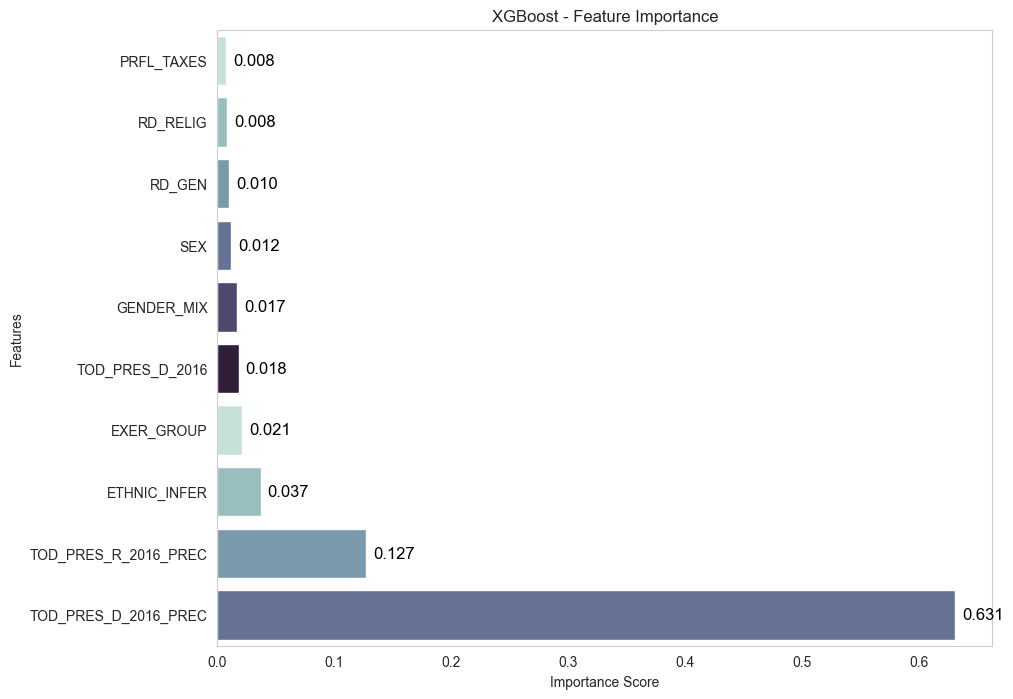

Elapsed time: 10.71 seconds


,Run,Accuracy,Recall,F1_Score,Precision,Top_N_Features
0,1,0.73997,0.740449,0.730151,0.720136,"[TOD_PRES_D_2016_PREC, TOD_PRES_R_2016_PREC, E..."


In [18]:
@timer_decorator
def run_xgboost_all_columns(data, num_runs=1):
    results_list = []
    le = LabelEncoder()  # Initialize the label encoder

    for run in range(1, num_runs + 1):
        print(f"Starting run {run}...")
        
        data_with_all_columns = data.copy()
        data_with_all_columns = data_with_all_columns[data_with_all_columns['INFER_PARTY'].notna()]
        
        print("Number of columns in the dataset:", len(data_with_all_columns.columns))

        # Convert object columns to category type
        for col in data_with_all_columns.select_dtypes(['object']).columns:
            data_with_all_columns[col] = data_with_all_columns[col].astype('category')

        # Splitting the data into features and target without encoding feature columns
        X = data_with_all_columns.drop('INFER_PARTY', axis=1)
        
        # Encoding the target column 'INFER_PARTY'
        y = le.fit_transform(data_with_all_columns['INFER_PARTY'])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        xgb = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), random_state=42, enable_categorical=True)
        xgb.fit(X_train, y_train)
        
        y_pred = xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, zero_division='warn')
        precision = precision_score(y_test, y_pred, zero_division='warn')

        print(f"Run {run} - Baseline Metrics: Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}, Precision: {precision}")

        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:10]
        top_features = X.columns[sorted_idx].tolist()
        top_importances = feature_importances[sorted_idx]

        plot_feature_importance(top_importances, top_features, 'XGBoost')

        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'Recall': recall,
            'F1_Score': f1,
            'Precision': precision,
            'Top_N_Features': top_features
        })

    result_df = pd.DataFrame(results_list)
    return result_df

def plot_feature_importance(importance, names, model_type):
    feature_importance = pd.DataFrame({'feature': names, 'importance': importance})
    feature_importance = feature_importance.sort_values(by='importance', ascending=True)
    
    plt.figure(figsize=(10, 8))
    
    cubehelix_palette = sns.cubehelix_palette(start=.5, rot=-.5)
    
    ax = sns.barplot(x="importance", y="feature", data=feature_importance, palette=cubehelix_palette)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.3f}', 
                    (p.get_width(), p.get_y() + p.get_height() / 2.), 
                    ha='left', 
                    va='center', 
                    fontsize=12, 
                    color='black',
                    xytext=(5, 0), 
                    textcoords='offset points')
    
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(False)
    plt.show()

# Assuming processed_data is already defined
result = run_xgboost_all_columns(processed_data, num_runs=1)
result

In [ ]:
@timer_decorator
def run_xgboost_all_columns(data, num_runs=1, top_N_features=50):
    results_list = []
    le = LabelEncoder()  # Initialize the label encoder

    for run in range(1, num_runs + 1):
        print(f"Starting run {run}...")
        
        data_with_all_columns = data.copy()
        data_with_all_columns = data_with_all_columns[data_with_all_columns['INFER_PARTY'].notna()]

        # Convert object columns to category type
        for col in data_with_all_columns.select_dtypes(['object']).columns:
            data_with_all_columns[col] = data_with_all_columns[col].astype('category')

        # Splitting the data into features and target without encoding feature columns
        X = data_with_all_columns.drop('INFER_PARTY', axis=1)
        
        # Encoding the target column 'INFER_PARTY'
        y = le.fit_transform(data_with_all_columns['INFER_PARTY'])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        xgb = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), random_state=42, enable_categorical=True)
        xgb.fit(X_train, y_train)
        
        y_pred = xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, zero_division='warn')
        precision = precision_score(y_test, y_pred)

        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
        top_features = X.columns[sorted_idx].tolist()
        
        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1_Score': f1,
            'Top_N_Features': top_features
        })

    result_df = pd.DataFrame(results_list)
    return result_df

# Assuming processed_data is already defined
result = run_xgboost_all_columns(processed_data, num_runs=1, top_N_features=10)
result

In [ ]:
@timer_decorator
def run_xgboost_all_columns(data, sample_size=500, num_runs=1, top_N_features=50):
    results_list = []
    le = LabelEncoder()  # Initialize the label encoder

    for run in range(1, num_runs + 1):
        print(f"Starting run {run}...")
        
        data_with_all_columns = data.copy()
        data_with_all_columns = data_with_all_columns[data_with_all_columns['INFER_PARTY'].notna()]
        
        print("Number of columns in the dataset:", len(data_with_all_columns.columns))

        data_sample = data_with_all_columns.sample(n=sample_size, random_state=42)

        # Convert object columns to category type
        for col in data_sample.select_dtypes(['object']).columns:
            data_sample[col] = data_sample[col].astype('category')

        # Splitting the data into features and target without encoding feature columns
        X = data_sample.drop('INFER_PARTY', axis=1)
        
        # Encoding the target column 'INFER_PARTY'
        y = le.fit_transform(data_sample['INFER_PARTY'])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        xgb = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), random_state=42, enable_categorical=True)
        xgb.fit(X_train, y_train)
        
        y_pred = xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, zero_division='warn')

        print(f"Run {run} - Baseline Metrics: Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}")

        feature_importances = xgb.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1][:top_N_features]
        top_features = X.columns[sorted_idx].tolist()

        results_list.append({
            'Run': run,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'Top_N_Features': top_features
        })

    result_df = pd.DataFrame(results_list)
    return result_df

# Assuming engineered_data is already defined
result = run_xgboost_all_columns(engineered_data, sample_size=500, num_runs=1, top_N_features=50)
result